# 1. Import and clean data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed, save, load
import warnings
warnings.filterwarnings("ignore")
set_random_seed(99)

C:\Users\namtrantuan\AppData\Roaming\Python\Python39\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [2]:
pd.options.display.float_format = '{:20,.0f}'.format

In [3]:
dom = pd.read_excel('TTT.xlsx')

In [4]:
dom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    3008 non-null   datetime64[ns]
 1   Pax     3008 non-null   float64       
 2   seat    3008 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 70.6 KB


In [6]:
dom.set_index('DATE', inplace = True)

In [7]:
# df for model building:
df = dom[['SECTOR_2W','Pax','seat']].groupby('SECTOR_2W').resample('W').sum()
df.reset_index(inplace = True)
df.rename(columns = {'SECTOR_2W':'ID','FLT_DATE':'ds','Pax':'y'}, inplace = True)

KeyError: "['SECTOR_2W'] not in index"

In [ ]:
# changepoints là những mốc bắt đầu và kết thúc của các đợt dịch covid hoặc thay đổi về trend:
changepoints = ['2020-03-09',
                '2020-05-31',
                '2020-07-28',
                '2020-09-30',
                '2021-01-25',
                '2021-03-31',
                '2021-04-30',
                '2021-10-22',
                '2022-02-11',
                '2022-03-09',
                '2022-06-16']

In [8]:
df

,ID,ds,y,seat
0,(blank),2020-07-05,134,340
1,(blank),2020-07-12,659,1072
2,(blank),2020-07-19,799,1020
3,(blank),2020-07-26,982,1020
4,(blank),2020-08-02,628,1020
...,...,...,...,...
27889,VIIVCS,2020-11-29,0,0
27890,VIIVCS,2020-12-06,173,758
27891,VIIVCS,2020-12-13,57,566
27892,VIIVCS,2020-12-20,372,944


# 2. Build model

## 2.1. Routes with only route peaks

In [9]:
route = df[df['ID']=='HANSGN'][['ds','y','seat']]

In [10]:
route

,ds,y,seat
8819,2015-01-04,"53,720",65165
8820,2015-01-11,"90,970",105802
8821,2015-01-18,"88,542",104235
8822,2015-01-25,"90,713",113583
8823,2015-02-01,"96,799",113772
...,...,...,...
9245,2023-03-05,"163,052",195894
9246,2023-03-12,"167,621",195043
9247,2023-03-19,"94,612",110625
9248,2023-03-26,"59,481",72630


In [11]:
train = route[route['ds'] < '2022-07-01'].copy()
val = route[(route['ds'] >= '2022-07-01')&(route['ds'] < '2023-01-01')].copy()
test = route[route['ds'] >= '2023-01-01'].copy()

In [12]:
holidays = pd.read_excel('holidays.xlsx')
holidays = holidays.rename(columns={'holiday': 'event'})
holidays = holidays[holidays['event'].isin(['Lunar','Labor'])]

In [13]:
train_holidays = holidays[holidays['ds'] < '2022-07-01'].copy()
val_holidays = holidays[(holidays['ds'] >= '2022-07-01')&(holidays['ds'] < '2023-01-01')].copy()
test_holidays = holidays[holidays['ds'] >= '2023-01-01'].copy()

In [14]:
def objective(trial):
    set_random_seed(99)
    """Define the objective function"""

    params = {
        'trend_reg': trial.suggest_float('trend_reg',0.001,10),
        'seasonality_reg': trial.suggest_float('seasonality_reg',0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode',['multiplicative', 'additive']),
        'yearly_seasonality':trial.suggest_int('yearly_seasonality',10,40),
        'n_lags':trial.suggest_int('n_lags',1,53*3),
        'ar_reg':trial.suggest_float('ar_reg',0,10),
        #'newer_samples_weight':trial.suggest_float('newer_samples_weight',0,10),
        'learning_rate':trial.suggest_float('learning_rate',0.001,5),
        'num_hidden_layers':trial.suggest_int('num_hidden_layers',0,3)
    }
    lagged_regressor_params = {'regularization':trial.suggest_float('regularization',0,1)}
    
    # Create the model
    optuna_model = NeuralProphet(**params,
                                 changepoints = changepoints,
                                 daily_seasonality = False,
                                 weekly_seasonality= False,
                                 n_forecasts = 53)
    optuna_model.add_events(events = ['covid_1','covid_2','covid_3','covid_4'], mode='multiplicative')  
    optuna_model.add_events(events = ['Lunar','Labor'], mode='multiplicative')
    optuna_model.add_lagged_regressor('seat', **lagged_regressor_params)
    
    # create the data df with events
    train_df = optuna_model.create_df_with_events(train, train_holidays)
    val_df = optuna_model.create_df_with_events(val, val_holidays)
    
    # Fit the model
    metrics = optuna_model.fit(train_df, freq="W")

    # Make predictions
    future_df = optuna_model.make_future_dataframe(train_df, events_df=holidays)
    optuna_forecast = optuna_model.predict(df=future_df)
    latest = optuna_model.get_latest_forecast(optuna_forecast)

    # Evaluate prediction
    result = val_df.merge(latest,how = 'left', on = 'ds')
    result.set_index('ds', inplace = True)
    rmse = np.sqrt(mean_squared_error(result['y_x'], result['origin-0'])).round(0)
    return rmse

In [15]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=99))

[I 2023-04-11 17:04:13,019] A new study created in memory with name: no-name-054234af-c21a-4ad9-aef9-de281dd30a30


In [16]:
study.optimize(objective, n_trials=100)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (90)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.con

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.301% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.301% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 16it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:04:54,590] Trial 0 finished with value: 279654.0 and parameters: {'trend_reg': 6.723113307749288, 'seasonality_reg': 4.931976152481779, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 35, 'n_lags': 90, 'ar_reg': 2.9762249870394397, 'learning_rate': 0.2344319068142593, 'num_hidden_layers': 3, 'regularization': 0.006825733043655191}. Best is trial 0 with value: 279654.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (63)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaste

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.138% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.138% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:05:27,880] Trial 1 finished with value: 214877.0 and parameters: {'trend_reg': 7.698160488871209, 'seasonality_reg': 7.492994299843566, 'seasonality_mode': 'additive', 'yearly_seasonality': 38, 'n_lags': 63, 'ar_reg': 9.7395629682896, 'learning_rate': 2.622549162160825, 'num_hidden_layers': 0, 'regularization': 0.813308412782129}. Best is trial 1 with value: 214877.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (36)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.876% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.876% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:06:03,240] Trial 2 finished with value: 533163.0 and parameters: {'trend_reg': 2.1176561691080455, 'seasonality_reg': 5.588023267447785, 'seasonality_mode': 'additive', 'yearly_seasonality': 35, 'n_lags': 36, 'ar_reg': 6.448347016033116, 'learning_rate': 0.4768129280457185, 'num_hidden_layers': 1, 'regularization': 0.09686526126266715}. Best is trial 1 with value: 214877.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (2)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.182% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.182% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 22it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:06:37,411] Trial 3 finished with value: 29252.0 and parameters: {'trend_reg': 1.4409659780779387, 'seasonality_reg': 2.2007421356240147, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'n_lags': 2, 'ar_reg': 8.986441870723997, 'learning_rate': 2.7616198999614383, 'num_hidden_layers': 0, 'regularization': 0.9288781834957359}. Best is trial 3 with value: 29252.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (133)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.462% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.462% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:07:09,912] Trial 4 finished with value: 269714.0 and parameters: {'trend_reg': 5.421334900480403, 'seasonality_reg': 0.513409459812975, 'seasonality_mode': 'additive', 'yearly_seasonality': 34, 'n_lags': 133, 'ar_reg': 2.526322301523826, 'learning_rate': 4.841399290363644, 'num_hidden_layers': 1, 'regularization': 0.264091169854872}. Best is trial 3 with value: 29252.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (134)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.465% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.465% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:07:45,918] Trial 5 finished with value: 307508.0 and parameters: {'trend_reg': 5.4942347997429035, 'seasonality_reg': 3.8356044937294285, 'seasonality_mode': 'additive', 'yearly_seasonality': 39, 'n_lags': 134, 'ar_reg': 4.3278933519110705, 'learning_rate': 3.580848646659412, 'num_hidden_layers': 3, 'regularization': 0.0790466853113343}. Best is trial 3 with value: 29252.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (33)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 20it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:08:24,809] Trial 6 finished with value: 44138.0 and parameters: {'trend_reg': 4.100175402884403, 'seasonality_reg': 6.45154399765729, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'n_lags': 33, 'ar_reg': 2.9306511293389037, 'learning_rate': 0.8008903600834841, 'num_hidden_layers': 1, 'regularization': 0.7185063797778265}. Best is trial 3 with value: 29252.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (111)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fi

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.39% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.39% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 15it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:08:55,369] Trial 7 finished with value: 283146.0 and parameters: {'trend_reg': 9.57984200939192, 'seasonality_reg': 0.2562439814963622, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 37, 'n_lags': 111, 'ar_reg': 8.265585239711491, 'learning_rate': 4.5918223953938035, 'num_hidden_layers': 0, 'regularization': 0.47002862075489793}. Best is trial 3 with value: 29252.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (17)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 21it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:09:38,706] Trial 8 finished with value: 238676.0 and parameters: {'trend_reg': 5.463140085069839, 'seasonality_reg': 5.21090379223616, 'seasonality_mode': 'additive', 'yearly_seasonality': 17, 'n_lags': 17, 'ar_reg': 6.138800418290888, 'learning_rate': 1.2190378638468025, 'num_hidden_layers': 3, 'regularization': 0.46552921506558087}. Best is trial 3 with value: 29252.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (38)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.901% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.901% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:10:17,881] Trial 9 finished with value: 162046.0 and parameters: {'trend_reg': 6.910607756605617, 'seasonality_reg': 3.612549841498813, 'seasonality_mode': 'additive', 'yearly_seasonality': 15, 'n_lags': 38, 'ar_reg': 5.444174127245024, 'learning_rate': 1.7752011724836596, 'num_hidden_layers': 2, 'regularization': 0.6481588203970642}. Best is trial 3 with value: 29252.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (5)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - Wh

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.276% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.276% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 21it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:10:50,870] Trial 10 finished with value: 390866.0 and parameters: {'trend_reg': 0.07214071931517552, 'seasonality_reg': 9.138679442485788, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'n_lags': 5, 'ar_reg': 0.5472984477576563, 'learning_rate': 2.6018515381155587, 'num_hidden_layers': 0, 'regularization': 0.966768210571676}. Best is trial 3 with value: 29252.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (49)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.02% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.02% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:11:28,261] Trial 11 finished with value: 28530.0 and parameters: {'trend_reg': 2.704142414505869, 'seasonality_reg': 2.1548116738524596, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'n_lags': 49, 'ar_reg': 0.0940122888707946, 'learning_rate': 1.5597258317030838, 'num_hidden_layers': 1, 'regularization': 0.9923202740390192}. Best is trial 11 with value: 28530.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (67)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.167% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.167% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:12:05,585] Trial 12 finished with value: 77701.0 and parameters: {'trend_reg': 2.2279541468504114, 'seasonality_reg': 2.352864668798997, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'n_lags': 67, 'ar_reg': 0.27918995253792644, 'learning_rate': 1.8689167825174973, 'num_hidden_layers': 2, 'regularization': 0.9806686604118249}. Best is trial 11 with value: 28530.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (3)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.214% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.214% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 21it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:12:39,704] Trial 13 finished with value: 151242.0 and parameters: {'trend_reg': 2.182556040754578, 'seasonality_reg': 1.8578615354593433, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'n_lags': 3, 'ar_reg': 7.908194723109894, 'learning_rate': 3.53519312800769, 'num_hidden_layers': 0, 'regularization': 0.8330586911988318}. Best is trial 11 with value: 28530.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (55)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fi

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.074% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.074% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:13:13,534] Trial 14 finished with value: 184291.0 and parameters: {'trend_reg': 0.2956718193064827, 'seasonality_reg': 1.7260441903186692, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'n_lags': 55, 'ar_reg': 9.486556432874817, 'learning_rate': 3.323853610191364, 'num_hidden_layers': 1, 'regularization': 0.9984762690724476}. Best is trial 11 with value: 28530.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (85)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.275% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.275% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 16it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:13:49,558] Trial 15 finished with value: 94784.0 and parameters: {'trend_reg': 3.8217111179599, 'seasonality_reg': 2.9175798326014557, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'n_lags': 85, 'ar_reg': 7.517038279679799, 'learning_rate': 1.8027491362718413, 'num_hidden_layers': 2, 'regularization': 0.5984255100566541}. Best is trial 11 with value: 28530.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (26)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fi

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.734% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.734% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 20it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:14:23,137] Trial 16 finished with value: 84546.0 and parameters: {'trend_reg': 1.3107799615667477, 'seasonality_reg': 1.0715481815778969, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'n_lags': 26, 'ar_reg': 1.200054251007912, 'learning_rate': 1.2026057915790713, 'num_hidden_layers': 0, 'regularization': 0.8541106375025014}. Best is trial 11 with value: 28530.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (52)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.048% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.048% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:14:58,519] Trial 17 finished with value: 286334.0 and parameters: {'trend_reg': 3.950612781256523, 'seasonality_reg': 3.6574329823795853, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'n_lags': 52, 'ar_reg': 4.526236873704285, 'learning_rate': 2.9643530571778105, 'num_hidden_layers': 1, 'regularization': 0.3565763275304734}. Best is trial 11 with value: 28530.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (102)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaste

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.355% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.355% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 15it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:15:26,388] Trial 18 finished with value: 246179.0 and parameters: {'trend_reg': 3.217582460816806, 'seasonality_reg': 1.5078413146579885, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 11, 'n_lags': 102, 'ar_reg': 1.7317068371713766, 'learning_rate': 4.127152661992255, 'num_hidden_layers': 0, 'regularization': 0.7355063525072928}. Best is trial 11 with value: 28530.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (12)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaste

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.462% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.462% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 21it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:16:01,388] Trial 19 finished with value: 105850.0 and parameters: {'trend_reg': 1.320224796716701, 'seasonality_reg': 2.937395815121184, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'n_lags': 12, 'ar_reg': 3.7377854603030567, 'learning_rate': 2.246831048721443, 'num_hidden_layers': 1, 'regularization': 0.888542987004417}. Best is trial 11 with value: 28530.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (46)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.99% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.99% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:16:38,426] Trial 20 finished with value: 24373.0 and parameters: {'trend_reg': 2.977060810925074, 'seasonality_reg': 4.404261500746712, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'n_lags': 46, 'ar_reg': 8.745940759282803, 'learning_rate': 1.354920241061358, 'num_hidden_layers': 2, 'regularization': 0.5998822733248828}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (53)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fi

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.057% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.057% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:17:14,524] Trial 21 finished with value: 37754.0 and parameters: {'trend_reg': 3.105407818387642, 'seasonality_reg': 4.345474017001797, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'n_lags': 53, 'ar_reg': 8.91968901307205, 'learning_rate': 1.2711994312924235, 'num_hidden_layers': 2, 'regularization': 0.5952395255630556}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (74)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fi

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:17:50,452] Trial 22 finished with value: 153315.0 and parameters: {'trend_reg': 1.1891302277414706, 'seasonality_reg': 2.7441145147283437, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'n_lags': 74, 'ar_reg': 7.166483844480229, 'learning_rate': 2.118856090540088, 'num_hidden_layers': 2, 'regularization': 0.7449061790933237}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (157)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaste

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.524% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.524% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 12it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:18:23,371] Trial 23 finished with value: 147733.0 and parameters: {'trend_reg': 3.120726829565517, 'seasonality_reg': 6.784784462416155, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'n_lags': 157, 'ar_reg': 8.71766256088841, 'learning_rate': 1.4756025590146273, 'num_hidden_layers': 2, 'regularization': 0.9101213991473402}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (43)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.958% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.958% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:18:58,907] Trial 24 finished with value: 52050.0 and parameters: {'trend_reg': 4.4794983531473695, 'seasonality_reg': 4.235938855998491, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'n_lags': 43, 'ar_reg': 6.770903121590164, 'learning_rate': 0.8470316266111343, 'num_hidden_layers': 1, 'regularization': 0.3528093373855086}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (20)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.63% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.63% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 20it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:19:37,335] Trial 25 finished with value: 141993.0 and parameters: {'trend_reg': 2.4868086941269674, 'seasonality_reg': 0.972652098701503, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 32, 'n_lags': 20, 'ar_reg': 5.614075096270831, 'learning_rate': 2.972246385535601, 'num_hidden_layers': 2, 'regularization': 0.787203404006656}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (27)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 20it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:20:12,004] Trial 26 finished with value: 143948.0 and parameters: {'trend_reg': 0.9056501459064328, 'seasonality_reg': 9.553927806312398, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'n_lags': 27, 'ar_reg': 9.072192640533586, 'learning_rate': 2.3652804814660966, 'num_hidden_layers': 1, 'regularization': 0.6703944291785491}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (45)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.98% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.98% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:20:44,184] Trial 27 finished with value: 223435.0 and parameters: {'trend_reg': 2.8098605020459253, 'seasonality_reg': 2.0863555119797272, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'n_lags': 45, 'ar_reg': 9.980670329780033, 'learning_rate': 0.0856116279434993, 'num_hidden_layers': 0, 'regularization': 0.9306323556373353}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (59)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaste

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.107% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.107% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:21:22,226] Trial 28 finished with value: 175379.0 and parameters: {'trend_reg': 1.7370488798427113, 'seasonality_reg': 5.997948264281383, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'n_lags': 59, 'ar_reg': 7.892102067046032, 'learning_rate': 1.576307891917183, 'num_hidden_layers': 3, 'regularization': 0.5327937752761588}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (78)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.237% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.237% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:22:00,606] Trial 29 finished with value: 1036874.0 and parameters: {'trend_reg': 0.5434712167247167, 'seasonality_reg': 4.854935916283529, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'n_lags': 78, 'ar_reg': 3.4830465169448095, 'learning_rate': 0.46262292077885114, 'num_hidden_layers': 3, 'regularization': 0.35977146755192735}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (2)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecas

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.182% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.182% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 22it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:22:36,464] Trial 30 finished with value: 186936.0 and parameters: {'trend_reg': 4.740053972161057, 'seasonality_reg': 7.818384556704464, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'n_lags': 2, 'ar_reg': 1.9817927147465837, 'learning_rate': 0.9056998513758265, 'num_hidden_layers': 1, 'regularization': 0.9050366567041002}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (47)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:23:13,593] Trial 31 finished with value: 26603.0 and parameters: {'trend_reg': 3.468148137975537, 'seasonality_reg': 4.811782439271851, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'n_lags': 47, 'ar_reg': 8.925847970299998, 'learning_rate': 1.2071304133903868, 'num_hidden_layers': 2, 'regularization': 0.5764886499939018}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (95)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.324% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.324% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 16it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:23:48,459] Trial 32 finished with value: 98108.0 and parameters: {'trend_reg': 3.727620544499252, 'seasonality_reg': 4.765847391550199, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'n_lags': 95, 'ar_reg': 8.391438952747942, 'learning_rate': 2.0252427409499023, 'num_hidden_layers': 2, 'regularization': 0.5270412897879952}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (71)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.194% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.194% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:24:23,203] Trial 33 finished with value: 737032.0 and parameters: {'trend_reg': 1.798172043496188, 'seasonality_reg': 3.5074336114446503, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 12, 'n_lags': 71, 'ar_reg': 9.221159620257765, 'learning_rate': 0.5622312678745413, 'num_hidden_layers': 2, 'regularization': 0.41821962942676116}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (31)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaste

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 20it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:25:01,182] Trial 34 finished with value: 200560.0 and parameters: {'trend_reg': 2.7089364036186048, 'seasonality_reg': 5.552465372545908, 'seasonality_mode': 'additive', 'yearly_seasonality': 32, 'n_lags': 31, 'ar_reg': 7.193160508163407, 'learning_rate': 2.8568519509322265, 'num_hidden_layers': 2, 'regularization': 0.7991161108969564}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (47)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:25:41,632] Trial 35 finished with value: 122174.0 and parameters: {'trend_reg': 3.438339102711097, 'seasonality_reg': 7.883137340398099, 'seasonality_mode': 'additive', 'yearly_seasonality': 23, 'n_lags': 47, 'ar_reg': 9.796598416248475, 'learning_rate': 1.525048304734053, 'num_hidden_layers': 3, 'regularization': 0.2505162197585669}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (65)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.153% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.153% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:26:15,827] Trial 36 finished with value: 159082.0 and parameters: {'trend_reg': 5.981379803256713, 'seasonality_reg': 4.278350729007479, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'n_lags': 65, 'ar_reg': 8.57111204171625, 'learning_rate': 1.0752856402270272, 'num_hidden_layers': 1, 'regularization': 0.2393423986116605}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (14)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.507% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.507% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 21it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:26:50,274] Trial 37 finished with value: 232630.0 and parameters: {'trend_reg': 9.842061126126465, 'seasonality_reg': 2.5330024862256355, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'n_lags': 14, 'ar_reg': 6.290787197187078, 'learning_rate': 0.3861179144649399, 'num_hidden_layers': 0, 'regularization': 0.5973774746873145}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (111)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaste

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.39% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.39% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 15it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:27:22,620] Trial 38 finished with value: 79889.0 and parameters: {'trend_reg': 1.6528348883769164, 'seasonality_reg': 3.091767697803479, 'seasonality_mode': 'additive', 'yearly_seasonality': 13, 'n_lags': 111, 'ar_reg': 8.005871018454412, 'learning_rate': 2.32167415212154, 'num_hidden_layers': 1, 'regularization': 0.6342900275140462}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (38)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.901% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.901% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:28:00,247] Trial 39 finished with value: 45208.0 and parameters: {'trend_reg': 4.276714836984159, 'seasonality_reg': 6.928225560991164, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'n_lags': 38, 'ar_reg': 9.369197578419522, 'learning_rate': 0.6798312066140828, 'num_hidden_layers': 2, 'regularization': 0.7221068003983333}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (21)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.649% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.649% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 20it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:28:39,800] Trial 40 finished with value: 49446.0 and parameters: {'trend_reg': 8.1021783930885, 'seasonality_reg': 0.9904312654368441, 'seasonality_mode': 'additive', 'yearly_seasonality': 17, 'n_lags': 21, 'ar_reg': 4.779053850436293, 'learning_rate': 2.6362781625054708, 'num_hidden_layers': 3, 'regularization': 0.09542376655081763}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (51)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.038% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.038% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:29:15,301] Trial 41 finished with value: 37581.0 and parameters: {'trend_reg': 2.8943171260678593, 'seasonality_reg': 4.2917317889090265, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'n_lags': 51, 'ar_reg': 8.874247955529595, 'learning_rate': 1.3926305203105436, 'num_hidden_layers': 2, 'regularization': 0.5603924960383317}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (62)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.13% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.13% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:29:51,556] Trial 42 finished with value: 214677.0 and parameters: {'trend_reg': 4.984795573286077, 'seasonality_reg': 5.269727541409807, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'n_lags': 62, 'ar_reg': 8.57186611647789, 'learning_rate': 1.4499258649328157, 'num_hidden_layers': 2, 'regularization': 0.5273092723352542}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (38)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.901% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.901% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:30:27,172] Trial 43 finished with value: 146896.0 and parameters: {'trend_reg': 2.3363423609416527, 'seasonality_reg': 5.846250145947117, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'n_lags': 38, 'ar_reg': 7.377627552321032, 'learning_rate': 1.052433065815577, 'num_hidden_layers': 2, 'regularization': 0.44634536524876023}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (82)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.259% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.259% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:31:02,350] Trial 44 finished with value: 59404.0 and parameters: {'trend_reg': 3.4871609622105244, 'seasonality_reg': 3.2789091702998503, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'n_lags': 82, 'ar_reg': 9.550002252368737, 'learning_rate': 1.6853037302580671, 'num_hidden_layers': 2, 'regularization': 0.9541594058872875}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (48)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.01% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.01% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:31:39,425] Trial 45 finished with value: 44610.0 and parameters: {'trend_reg': 2.7722870814894, 'seasonality_reg': 4.6328702218725475, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'n_lags': 48, 'ar_reg': 6.735390679672718, 'learning_rate': 1.3340851087872418, 'num_hidden_layers': 2, 'regularization': 0.6748014967243186}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (58)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fi

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.099% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.099% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:32:09,805] Trial 46 finished with value: 85329.0 and parameters: {'trend_reg': 2.052119485682158, 'seasonality_reg': 0.27260332277641997, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'n_lags': 58, 'ar_reg': 5.538633533024565, 'learning_rate': 1.9587553866813858, 'num_hidden_layers': 0, 'regularization': 0.8467405620225916}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (31)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 20it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:32:45,230] Trial 47 finished with value: 78368.0 and parameters: {'trend_reg': 0.8104409844433752, 'seasonality_reg': 2.2589446437346052, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 40, 'n_lags': 31, 'ar_reg': 7.998498133556382, 'learning_rate': 3.239550311861143, 'num_hidden_layers': 1, 'regularization': 0.5475916115988118}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (11)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.438% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.438% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 21it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:33:22,857] Trial 48 finished with value: 125617.0 and parameters: {'trend_reg': 5.32144714733359, 'seasonality_reg': 4.023148106416073, 'seasonality_mode': 'additive', 'yearly_seasonality': 19, 'n_lags': 11, 'ar_reg': 2.517433008438875, 'learning_rate': 4.163573129234949, 'num_hidden_layers': 2, 'regularization': 0.025578896512811866}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (91)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.306% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.306% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 16it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:33:59,434] Trial 49 finished with value: 144346.0 and parameters: {'trend_reg': 6.234491482288234, 'seasonality_reg': 1.4330932142617199, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'n_lags': 91, 'ar_reg': 9.01728908651462, 'learning_rate': 1.02097528808459, 'num_hidden_layers': 3, 'regularization': 0.4730737920951975}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (42)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fi

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.947% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.947% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:34:34,365] Trial 50 finished with value: 260848.0 and parameters: {'trend_reg': 4.300914484270262, 'seasonality_reg': 6.3074349716434295, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 36, 'n_lags': 42, 'ar_reg': 9.993498611886789, 'learning_rate': 2.496291214700003, 'num_hidden_layers': 1, 'regularization': 0.1931250775060443}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (53)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.057% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.057% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:35:10,186] Trial 51 finished with value: 56428.0 and parameters: {'trend_reg': 3.078490128906442, 'seasonality_reg': 4.410245987039523, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'n_lags': 53, 'ar_reg': 8.838132873820362, 'learning_rate': 1.8431191413930326, 'num_hidden_layers': 2, 'regularization': 0.5752506021646225}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (69)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:35:45,255] Trial 52 finished with value: 25399.0 and parameters: {'trend_reg': 3.6293056643815342, 'seasonality_reg': 5.243835510356342, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'n_lags': 69, 'ar_reg': 7.666965525668664, 'learning_rate': 1.250198318420894, 'num_hidden_layers': 2, 'regularization': 0.6253848131480211}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (70)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.187% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.187% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:36:20,479] Trial 53 finished with value: 26689.0 and parameters: {'trend_reg': 3.6621997163303055, 'seasonality_reg': 5.322148468056024, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'n_lags': 70, 'ar_reg': 8.23871087361768, 'learning_rate': 1.3067303160994461, 'num_hidden_layers': 2, 'regularization': 0.6240859086180469}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (75)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.219% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.219% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:36:56,115] Trial 54 finished with value: 32194.0 and parameters: {'trend_reg': 3.7767965030233466, 'seasonality_reg': 5.262009020423321, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'n_lags': 75, 'ar_reg': 7.610996606126109, 'learning_rate': 1.190504486515597, 'num_hidden_layers': 2, 'regularization': 0.6863425169309753}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (68)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.174% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.174% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:37:32,394] Trial 55 finished with value: 117436.0 and parameters: {'trend_reg': 3.5435950405264056, 'seasonality_reg': 5.036798600866979, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'n_lags': 68, 'ar_reg': 8.166443616842104, 'learning_rate': 0.727059527870361, 'num_hidden_layers': 2, 'regularization': 0.6235405566342589}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (86)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.281% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.281% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 16it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:38:09,266] Trial 56 finished with value: 169262.0 and parameters: {'trend_reg': 4.6966988070173254, 'seasonality_reg': 3.8682887034660234, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'n_lags': 86, 'ar_reg': 8.319540370561215, 'learning_rate': 1.6544766579347394, 'num_hidden_layers': 2, 'regularization': 0.7871828187885818}. Best is trial 20 with value: 24373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (64)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaste

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.145% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.145% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:38:46,044] Trial 57 finished with value: 23572.0 and parameters: {'trend_reg': 2.435376431951377, 'seasonality_reg': 6.881200655611756, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'n_lags': 64, 'ar_reg': 6.901776629614256, 'learning_rate': 2.1339572941268514, 'num_hidden_layers': 1, 'regularization': 0.867445697954004}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (64)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fi

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.145% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.145% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:39:22,610] Trial 58 finished with value: 24185.0 and parameters: {'trend_reg': 2.4116373438878123, 'seasonality_reg': 8.397523951369719, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'n_lags': 64, 'ar_reg': 6.769661728032013, 'learning_rate': 2.0529956766315633, 'num_hidden_layers': 1, 'regularization': 0.4994014894620621}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (62)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.13% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.13% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:39:59,037] Trial 59 finished with value: 46855.0 and parameters: {'trend_reg': 2.5266670759581475, 'seasonality_reg': 8.30840539012702, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'n_lags': 62, 'ar_reg': 6.737028044669533, 'learning_rate': 2.1814849067041857, 'num_hidden_layers': 1, 'regularization': 0.40710746044127344}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (70)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.187% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.187% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:40:34,222] Trial 60 finished with value: 151131.0 and parameters: {'trend_reg': 3.991807574807428, 'seasonality_reg': 7.078111723625344, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'n_lags': 70, 'ar_reg': 6.150226033357214, 'learning_rate': 1.7774540194098916, 'num_hidden_layers': 1, 'regularization': 0.4913160643304375}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (58)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.099% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.099% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:41:10,529] Trial 61 finished with value: 57919.0 and parameters: {'trend_reg': 2.0667450138672785, 'seasonality_reg': 9.078601444778993, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'n_lags': 58, 'ar_reg': 7.581645475652044, 'learning_rate': 2.0550521768544994, 'num_hidden_layers': 1, 'regularization': 0.7644411069478968}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (73)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:41:46,262] Trial 62 finished with value: 39829.0 and parameters: {'trend_reg': 3.2431174034268295, 'seasonality_reg': 6.4197369719868975, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 34, 'n_lags': 73, 'ar_reg': 6.992341505378038, 'learning_rate': 1.2540747824917358, 'num_hidden_layers': 1, 'regularization': 0.9938236925852424}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (79)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.242% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.242% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-11 17:42:21,978] Trial 63 finished with value: 55318.0 and parameters: {'trend_reg': 2.4393227430680486, 'seasonality_reg': 7.364975134967768, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'n_lags': 79, 'ar_reg': 7.841471515496242, 'learning_rate': 1.6374868725809741, 'num_hidden_layers': 1, 'regularization': 0.8733778288541784}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (64)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.145% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.145% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:41:05,412] Trial 64 finished with value: 196781.0 and parameters: {'trend_reg': 1.9532152354743635, 'seasonality_reg': 8.417095471642206, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'n_lags': 64, 'ar_reg': 6.412916745365196, 'learning_rate': 0.9192743382826477, 'num_hidden_layers': 1, 'regularization': 0.6296180843341516}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (56)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.083% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.083% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:41:42,849] Trial 65 finished with value: 190021.0 and parameters: {'trend_reg': 4.095840637333219, 'seasonality_reg': 5.66521153115651, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'n_lags': 56, 'ar_reg': 5.925342824943469, 'learning_rate': 1.8692501264182328, 'num_hidden_layers': 1, 'regularization': 0.5014090934963786}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (49)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.02% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.02% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:42:23,506] Trial 66 finished with value: 42023.0 and parameters: {'trend_reg': 3.051231896793478, 'seasonality_reg': 6.224740198659173, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'n_lags': 49, 'ar_reg': 5.1004148247447265, 'learning_rate': 1.1540825337872598, 'num_hidden_layers': 2, 'regularization': 0.9343383965678341}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (41)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.936% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.936% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:43:04,257] Trial 67 finished with value: 189265.0 and parameters: {'trend_reg': 1.4875874258577957, 'seasonality_reg': 9.966558025291494, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 32, 'n_lags': 41, 'ar_reg': 0.6465339552324062, 'learning_rate': 1.4028903331702653, 'num_hidden_layers': 1, 'regularization': 0.5861339720586266}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (133)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecast

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.462% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.462% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:43:45,384] Trial 68 finished with value: 29665.0 and parameters: {'trend_reg': 3.491543438866486, 'seasonality_reg': 6.740211375716193, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'n_lags': 133, 'ar_reg': 3.6250114188653324, 'learning_rate': 2.4770238784560794, 'num_hidden_layers': 2, 'regularization': 0.696495468038254}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (34)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 20it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:44:29,648] Trial 69 finished with value: 60075.0 and parameters: {'trend_reg': 2.6676854714444613, 'seasonality_reg': 8.48059105861868, 'seasonality_mode': 'additive', 'yearly_seasonality': 26, 'n_lags': 34, 'ar_reg': 7.236500892227866, 'learning_rate': 1.5430707660286682, 'num_hidden_layers': 1, 'regularization': 0.8309073755744039}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (98)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.338% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.338% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 16it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:45:11,176] Trial 70 finished with value: 147031.0 and parameters: {'trend_reg': 2.2757010315418276, 'seasonality_reg': 5.498593486014307, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 34, 'n_lags': 98, 'ar_reg': 5.809767890224017, 'learning_rate': 0.2564433731778535, 'num_hidden_layers': 2, 'regularization': 0.6554438068651255}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (68)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.174% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.174% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:45:43,502] Trial 71 finished with value: 239734.0 and parameters: {'trend_reg': 1.3363040013485123, 'seasonality_reg': 1.7755021124749204, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'n_lags': 68, 'ar_reg': 9.26236848683078, 'learning_rate': 2.72382615464384, 'num_hidden_layers': 0, 'regularization': 0.9621784787020145}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (76)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.225% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.225% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:46:16,744] Trial 72 finished with value: 322296.0 and parameters: {'trend_reg': 3.248742531575692, 'seasonality_reg': 0.6900863878842909, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'n_lags': 76, 'ar_reg': 8.525745662420755, 'learning_rate': 2.1772355667135517, 'num_hidden_layers': 0, 'regularization': 0.8712867690111488}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (87)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.286% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.286% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 16it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:46:46,762] Trial 73 finished with value: 318488.0 and parameters: {'trend_reg': 1.7356744276220617, 'seasonality_reg': 3.4445508819501938, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'n_lags': 87, 'ar_reg': 7.732097070741103, 'learning_rate': 3.046226635354029, 'num_hidden_layers': 0, 'regularization': 0.9323696986795089}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (60)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.115% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.115% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:47:24,160] Trial 74 finished with value: 586227.0 and parameters: {'trend_reg': 1.0392345519452304, 'seasonality_reg': 5.960477200093364, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'n_lags': 60, 'ar_reg': 9.619518694372106, 'learning_rate': 0.9316659393901214, 'num_hidden_layers': 2, 'regularization': 0.6164412171007135}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (27)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 20it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:48:04,041] Trial 75 finished with value: 81509.0 and parameters: {'trend_reg': 0.5447458544935249, 'seasonality_reg': 7.678418066267171, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'n_lags': 27, 'ar_reg': 3.944958959781976, 'learning_rate': 1.93779932833303, 'num_hidden_layers': 2, 'regularization': 0.9063987530807677}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (55)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fi

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.074% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.074% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:48:41,862] Trial 76 finished with value: 101139.0 and parameters: {'trend_reg': 2.9072843725293716, 'seasonality_reg': 4.664393855743324, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'n_lags': 55, 'ar_reg': 8.238133308270543, 'learning_rate': 2.319007357823189, 'num_hidden_layers': 2, 'regularization': 0.3241179361950327}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (65)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.153% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.153% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:49:18,035] Trial 77 finished with value: 110698.0 and parameters: {'trend_reg': 3.6964067637291858, 'seasonality_reg': 1.308776748010541, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'n_lags': 65, 'ar_reg': 6.904307139016122, 'learning_rate': 1.7542991032298139, 'num_hidden_layers': 1, 'regularization': 0.6992440314661822}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (81)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.254% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.254% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:49:50,641] Trial 78 finished with value: 239428.0 and parameters: {'trend_reg': 2.5783355193323727, 'seasonality_reg': 2.6167284599541074, 'seasonality_mode': 'additive', 'yearly_seasonality': 15, 'n_lags': 81, 'ar_reg': 8.667961537291974, 'learning_rate': 2.765768980330708, 'num_hidden_layers': 0, 'regularization': 0.43122530843074924}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (6)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.305% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.305% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 21it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:50:30,239] Trial 79 finished with value: 1322973.0 and parameters: {'trend_reg': 0.02577001233951748, 'seasonality_reg': 5.0418688112663865, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'n_lags': 6, 'ar_reg': 9.081410216604585, 'learning_rate': 0.6221524050115401, 'num_hidden_layers': 2, 'regularization': 0.5072158298910772}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (46)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecast

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.99% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.99% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:51:08,485] Trial 80 finished with value: 115401.0 and parameters: {'trend_reg': 2.241092852888357, 'seasonality_reg': 2.9462951988901915, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'n_lags': 46, 'ar_reg': 7.410183391822662, 'learning_rate': 1.2789339025703135, 'num_hidden_layers': 2, 'regularization': 0.39368816423192865}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (137)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecast

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.474% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.474% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:51:43,488] Trial 81 finished with value: 54215.0 and parameters: {'trend_reg': 3.4682358852885287, 'seasonality_reg': 6.582430262616721, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'n_lags': 137, 'ar_reg': 3.097026958797759, 'learning_rate': 2.090626617642137, 'num_hidden_layers': 2, 'regularization': 0.7506122337262437}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (130)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.454% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.454% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 14it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:52:19,156] Trial 82 finished with value: 36743.0 and parameters: {'trend_reg': 4.576680281452037, 'seasonality_reg': 8.093917997299954, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'n_lags': 130, 'ar_reg': 1.2010217690548664, 'learning_rate': 1.5048099669536743, 'num_hidden_layers': 2, 'regularization': 0.5634841314721365}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (104)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaste

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.363% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.363% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 15it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:52:55,223] Trial 83 finished with value: 204982.0 and parameters: {'trend_reg': 4.3286112104654535, 'seasonality_reg': 6.698136124601167, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'n_lags': 104, 'ar_reg': 0.20812891979684914, 'learning_rate': 2.576091685378479, 'num_hidden_layers': 2, 'regularization': 0.7110035067034329}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (138)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecas

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.476% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.476% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:53:31,737] Trial 84 finished with value: 27515.0 and parameters: {'trend_reg': 3.32329237085784, 'seasonality_reg': 8.750841381164374, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 33, 'n_lags': 138, 'ar_reg': 5.232210169003852, 'learning_rate': 2.384647904763526, 'num_hidden_layers': 2, 'regularization': 0.9731249063071998}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (117)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.412% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.412% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 14it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:54:10,696] Trial 85 finished with value: 234851.0 and parameters: {'trend_reg': 8.47837742451585, 'seasonality_reg': 9.248054781008038, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 33, 'n_lags': 117, 'ar_reg': 8.095879099765819, 'learning_rate': 2.3722359968790063, 'num_hidden_layers': 3, 'regularization': 0.9804603574000013}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (52)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.048% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.048% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 18it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:54:52,167] Trial 86 finished with value: 67978.0 and parameters: {'trend_reg': 2.877607275652781, 'seasonality_reg': 7.508326320706516, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 36, 'n_lags': 52, 'ar_reg': 5.182463760698149, 'learning_rate': 1.1389082178297678, 'num_hidden_layers': 2, 'regularization': 0.9445317682978841}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (158)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.526% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.526% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 12it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:55:26,418] Trial 87 finished with value: 281352.0 and parameters: {'trend_reg': 3.8836307636709995, 'seasonality_reg': 7.178449443929256, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'n_lags': 158, 'ar_reg': 6.548458424908664, 'learning_rate': 0.8119173468740012, 'num_hidden_layers': 1, 'regularization': 0.9960515154911144}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (152)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecast

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.512% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.512% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 12it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:56:01,064] Trial 88 finished with value: 170095.0 and parameters: {'trend_reg': 3.2910719056511217, 'seasonality_reg': 8.959322543119232, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'n_lags': 152, 'ar_reg': 4.6927831084981175, 'learning_rate': 1.359976640711631, 'num_hidden_layers': 2, 'regularization': 0.9099954765371124}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (69)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaste

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:56:39,426] Trial 89 finished with value: 43105.0 and parameters: {'trend_reg': 1.920471032066554, 'seasonality_reg': 8.749552975664725, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 33, 'n_lags': 69, 'ar_reg': 8.793301236461202, 'learning_rate': 3.1479197352559836, 'num_hidden_layers': 2, 'regularization': 0.8842196550851454}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (72)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.2% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.2% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:57:14,724] Trial 90 finished with value: 221869.0 and parameters: {'trend_reg': 4.902030670830825, 'seasonality_reg': 9.444540000678728, 'seasonality_mode': 'additive', 'yearly_seasonality': 22, 'n_lags': 72, 'ar_reg': 4.406634430369852, 'learning_rate': 2.902941301531103, 'num_hidden_layers': 1, 'regularization': 0.6539798626467844}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (143)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.49% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.49% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:57:49,626] Trial 91 finished with value: 37837.0 and parameters: {'trend_reg': 3.4830738495730484, 'seasonality_reg': 5.351007676457936, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'n_lags': 143, 'ar_reg': 8.323371116765864, 'learning_rate': 3.5144960404234653, 'num_hidden_layers': 2, 'regularization': 0.6119925861723049}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (131)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaste

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.457% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.457% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:58:24,763] Trial 92 finished with value: 54036.0 and parameters: {'trend_reg': 3.673171672625276, 'seasonality_reg': 2.1288749298612744, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'n_lags': 131, 'ar_reg': 1.9868803381680542, 'learning_rate': 2.527845043300018, 'num_hidden_layers': 2, 'regularization': 0.5436459846825087}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (127)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaste

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.444% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.444% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 14it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:59:01,192] Trial 93 finished with value: 25547.0 and parameters: {'trend_reg': 2.9561097462393433, 'seasonality_reg': 5.770227201530271, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 38, 'n_lags': 127, 'ar_reg': 3.728599393967148, 'learning_rate': 2.4829848629581086, 'num_hidden_layers': 2, 'regularization': 0.9689419935575543}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (125)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaste

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.438% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.438% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 14it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 08:59:38,046] Trial 94 finished with value: 25620.0 and parameters: {'trend_reg': 2.9947748365997753, 'seasonality_reg': 4.4910968318431435, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 38, 'n_lags': 125, 'ar_reg': 9.408262438638744, 'learning_rate': 2.2425379417022637, 'num_hidden_layers': 2, 'regularization': 0.9628308028073034}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (124)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecast

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.435% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.435% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 14it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 09:00:12,910] Trial 95 finished with value: 28804.0 and parameters: {'trend_reg': 3.0722827208015904, 'seasonality_reg': 4.961840668911385, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 38, 'n_lags': 124, 'ar_reg': 9.275650494303756, 'learning_rate': 2.275243848376426, 'num_hidden_layers': 2, 'regularization': 0.9714697197523761}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (142)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.487% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.487% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 09:00:48,161] Trial 96 finished with value: 82008.0 and parameters: {'trend_reg': 2.653356109481643, 'seasonality_reg': 4.531498774837542, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 38, 'n_lags': 142, 'ar_reg': 2.4352364908752473, 'learning_rate': 1.9610690929793826, 'num_hidden_layers': 2, 'regularization': 0.9685374668650408}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (118)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaste

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.415% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.415% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 14it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 09:01:22,763] Trial 97 finished with value: 116168.0 and parameters: {'trend_reg': 2.4075920406867795, 'seasonality_reg': 5.731358928931134, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 39, 'n_lags': 118, 'ar_reg': 9.759057197951748, 'learning_rate': 1.7054387083356297, 'num_hidden_layers': 2, 'regularization': 0.9485667527947822}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (141)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecast

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.485% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.485% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 09:01:58,464] Trial 98 finished with value: 73695.0 and parameters: {'trend_reg': 4.149179060616182, 'seasonality_reg': 4.783124478549607, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 36, 'n_lags': 141, 'ar_reg': 3.0823839571948404, 'learning_rate': 2.215149720587025, 'num_hidden_layers': 2, 'regularization': 0.8199753653391457}. Best is trial 57 with value: 23572.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (121)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.744% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.425% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.425% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 14it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-12 09:02:35,684] Trial 99 finished with value: 28400.0 and parameters: {'trend_reg': 2.928073310232236, 'seasonality_reg': 3.990685553838032, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 40, 'n_lags': 121, 'ar_reg': 7.726787574056258, 'learning_rate': 2.453877210733732, 'num_hidden_layers': 2, 'regularization': 0.8544734184423246}. Best is trial 57 with value: 23572.0.


In [17]:
params =  study.best_trial.params
# params = {'trend_reg': 2.977060810925074, 'seasonality_reg': 4.404261500746712, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'n_lags': 46, 'ar_reg': 8.745940759282803, 'learning_rate': 1.354920241061358, 'num_hidden_layers': 2, 'regularization': 0.5998822733248828}

In [18]:
regularization = params.pop('regularization')

In [19]:
set_random_seed(99)

In [20]:
m = NeuralProphet(**params,
                  changepoints = changepoints,
                  daily_seasonality = False,
                  weekly_seasonality = False,
                  n_forecasts = 53)
m.add_events(events = ['covid_1','covid_2','covid_3','covid_4'], mode='multiplicative')
m.add_events(events = ['Lunar','Labor'], mode='multiplicative')
m.add_lagged_regressor('seat', regularization = regularization)

# create the data df with events
train_df = m.create_df_with_events(train, train_holidays)
val_df = m.create_df_with_events(val, val_holidays)
train_val_df = pd.concat([train_df,val_df])
test_df = m.create_df_with_events(test, test_holidays)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (64)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.76% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 302


Training: 0it [00:00, ?it/s]

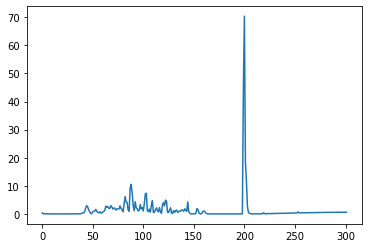

In [21]:
metrics = m.fit(train_val_df,
                freq="W",
                progress="plot")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


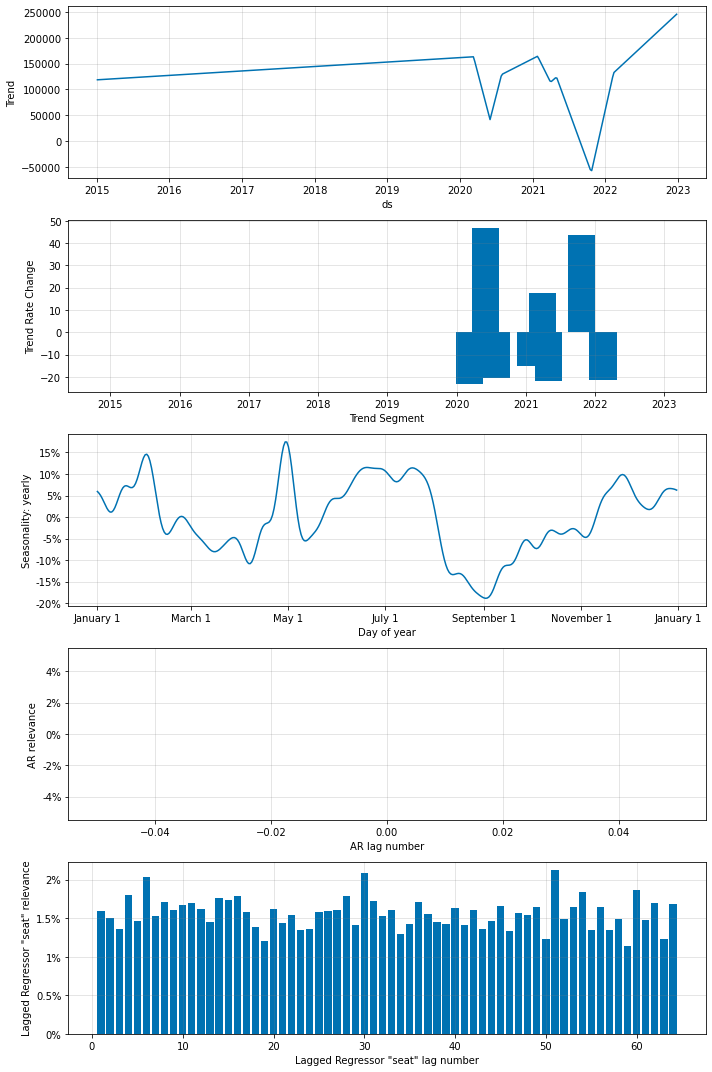

In [22]:
fig_param = m.plot_parameters()

In [23]:
future = m.make_future_dataframe(train_val_df, n_historic_predictions=True, events_df=holidays)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.76% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [24]:
future[(future['ds']>='2023-01-01')&(future['ds']<'2023-03-01')]

,ds,y,seat,covid_1,covid_2,covid_3,covid_4,Lunar,Labor
417,2023-01-01,NaN,None,0,0,0,0,0,0
418,2023-01-08,NaN,None,0,0,0,0,0,0
419,2023-01-15,NaN,None,0,0,0,0,1,0
420,2023-01-22,NaN,None,0,0,0,0,1,0
421,2023-01-29,NaN,None,0,0,0,0,1,0
422,2023-02-05,NaN,None,0,0,0,0,0,0
423,2023-02-12,NaN,None,0,0,0,0,0,0
424,2023-02-19,NaN,None,0,0,0,0,0,0
425,2023-02-26,NaN,None,0,0,0,0,0,0


INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.787% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.787% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


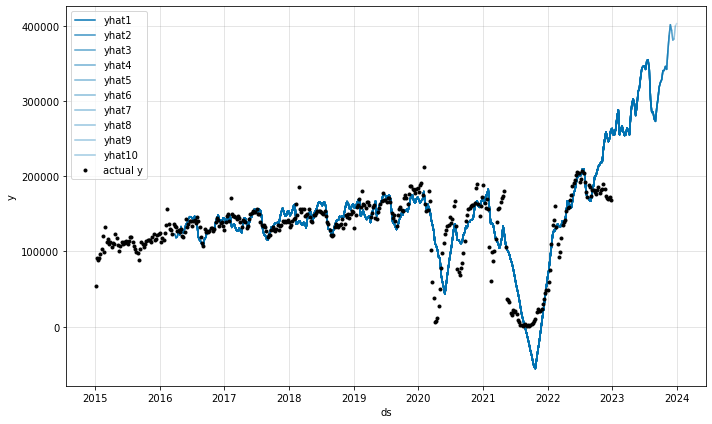

In [25]:
forecast = m.predict(future, decompose = False)
fig = m.plot(forecast)

In [26]:
latest = m.get_latest_forecast(forecast,include_history_data=True)

In [27]:
result = test_df.merge(latest,how = 'left', on = ['ds'])

In [28]:
result.to_excel('forecast.xlsx')

In [29]:
save(m,'HANSGN_daily.np')